# Álgebra matricial

En este libro tratamos de minimizar la notación matemática tanto como sea posible. Además, evitamos usar el cálculo para motivar conceptos estadísticos. Sin embargo, Matrix Algebra (también conocida como Linear Algebra) y su notación matemática facilita enormemente la exposición de las técnicas avanzadas de análisis de datos cubiertas en el resto de este libro. Por lo tanto, dedicamos un capítulo de este libro a la introducción de Matrix Algebra. Hacemos esto en el contexto del análisis de datos y utilizando una de las principales aplicaciones: Modelos lineales.

Describiremos tres ejemplos de las ciencias de la vida: uno de la física, uno relacionado con la genética y otro de un experimento con ratones. Son muy diferentes, pero terminamos usando la misma técnica estadística: ajustar modelos lineales. Los modelos lineales normalmente se enseñan y describen en el lenguaje del álgebra matricial.

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import random
import statistics
from sklearn.linear_model import LinearRegression
import statsmodels.api as sma
%matplotlib inline

## Ejemplos motivadores

#### Objetos que caen

Imagina que eres Galileo en el siglo XVI tratando de describir la velocidad de un objeto que cae. Un asistente sube a la Torre de Pisa y deja caer una pelota, mientras varios otros asistentes registran la posición en diferentes momentos. Simulemos algunos datos usando las ecuaciones que conocemos hoy y agregando algún error de medición:

In [2]:
np.random.seed(1)
g = 9.8 # metros por segundo
n = 25
tt = np.linspace(0,3.4,num=n)[..., None] #tiempo in segundos
rands = np.random.normal(0,1, n)[..., None]
d = 56.67 - 0.5 * g * tt * tt + rands

Los asistentes entregan los datos a Galileo y esto es lo que ve:

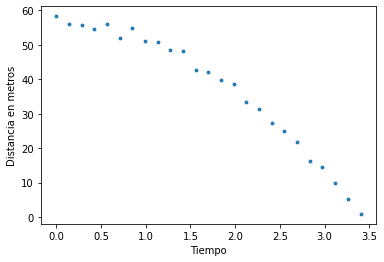

In [3]:
plt.scatter(tt, d, s = 8)
plt.xlabel('Tiempo')
plt.ylabel('Distancia en metros')
plt.show()

No conoce la ecuación exacta, pero al observar el gráfico anterior deduce que la posición debe seguir una parábola. Así que modela los datos con:

$$ Y_i = \beta_0 + \beta_1 x_i + \beta_2 x_i^2 + \varepsilon_i, i=1,\dots,n $$

Con $Y_i$ representando la ubicación, $x_i$ representando el tiempo y $\varepsilon_i$ representando el error de medición. Este es un modelo lineal porque es una combinación lineal de cantidades conocidas (las $x$) denominadas predictores o covariables y parámetros desconocidos (las $\beta$).

#### Alturas de padre e hijo
Ahora imagina que eres Francis Galton en el siglo XIX y recopilas datos de altura emparejados de padres e hijos. Sospechas que la altura se hereda. Tu información:

In [4]:
father_son = pd.read_csv('https://raw.githubusercontent.com/jabernalv/Father-Son-height/master/Pearson.csv')
x=father_son.fheight
y=father_son.sheight

Se ve como esto:

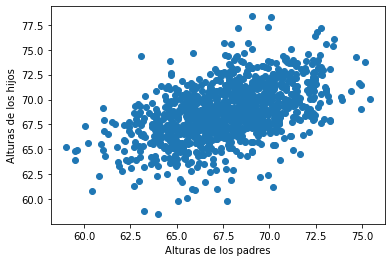

In [5]:
plt.scatter(x,y)
plt.xlabel("Alturas de los padres")
plt.ylabel("Alturas de los hijos")
plt.show()

Las alturas de los hijos parecen aumentar linealmente con las alturas de los padres. En este caso, un modelo que describe los datos es el siguiente:
$$ Y_i = \beta_0 + \beta_1 x_i + \varepsilon_i, i=1,\dots,N $$

Este también es un modelo lineal con $x_i$ y $Y_i$, las alturas del padre y el hijo respectivamente, para el $i$-ésimo par y $\varepsilon_i$ un término para tener en cuenta la variabilidad adicional. Aquí pensamos en las alturas de los padres como predictores y siendo fijos (no aleatorios), por lo que usamos minúsculas. El error de medición por sí solo no puede explicar toda la variabilidad observada en $\varepsilon_i$. Esto tiene sentido ya que hay otras variables que no están en el modelo, por ejemplo, la estatura de las madres, la aleatoriedad genética y los factores ambientales.

#### Muestras aleatorias de múltiples poblaciones

Aquí leemos datos de peso corporal de ratones que fueron alimentados con dos dietas diferentes: alta en grasas y control (chow). Tenemos una muestra aleatoria de 12 ratones para cada uno. Nos interesa determinar si la dieta tiene efecto sobre el peso. Aquí están los datos:

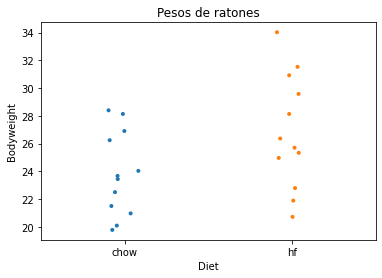

In [6]:
## https://www.machinelearningplus.com/plots/top-50-matplotlib-visualizations-the-master-plots-python/
url = "https://raw.githubusercontent.com/genomicsclass/dagdata/master/inst/extdata/femaleMiceWeights.csv"
dat = pd.read_csv(url)
sns.stripplot(x='Diet', y='Bodyweight',data=dat, jitter=1, size=4)
plt.title('Pesos de ratones')
plt.show()

Queremos estimar la diferencia en el peso promedio entre las poblaciones. Demostramos cómo hacer esto usando pruebas t e intervalos de confianza, basados ​​en la diferencia en los promedios de las muestras. Podemos obtener los mismos resultados exactos usando un modelo lineal:

$$ Y_i = \beta_0 + \beta_1 x_{i} + \varepsilon_i$$

con $\beta_0$ el peso promedio de la dieta chow, $\beta_1$ la diferencia entre los promedios, $x_i = 1$ cuando el ratón $i$ recibe la dieta alta en grasas (hf), $x_i = 0$ cuando recibe la dieta chow , y $\varepsilon_i$ explica las diferencias entre ratones de la misma población.
 

#### Modelos lineales en general

Hemos visto tres ejemplos muy diferentes en los que se pueden utilizar modelos lineales. Un modelo general que engloba todos los ejemplos anteriores es el siguiente:

$$ Y_i = \beta_0 + \beta_1 x_{i,1} + \beta_2 x_{i,2} + \dots + \beta_2 x_{i,p} + \varepsilon_i, i=1,\dots,n $$

 
$$ Y_i = \beta_0 + \sum_{j=1}^p \beta_j x_{i,j} + \varepsilon_i, i=1,\dots,n $$

Tenga en cuenta que tenemos un número general de predictores $p$. El álgebra matricial proporciona un lenguaje compacto y un marco matemático para calcular y hacer derivaciones con cualquier modelo lineal que se ajuste al marco anterior.

<a name="estimaciones"></a>

#### Estimación de parámetros

Para que los modelos anteriores sean útiles, tenemos que estimar los $\beta$ s desconocidos. En el primer ejemplo, queremos describir un proceso físico para el cual no podemos tener parámetros desconocidos. En el segundo ejemplo, entendemos mejor la herencia al estimar cuánto, en promedio, la altura del padre afecta la altura del hijo. En el ejemplo final, queremos determinar si de hecho hay una diferencia: si $\beta_1 \neq 0$.

El enfoque estándar en ciencia es encontrar los valores que minimizan la distancia del modelo ajustado a los datos. La siguiente se llama ecuación de mínimos cuadrados (LS) y la veremos a menudo en este capítulo:

$$ \sum_{i=1}^n \left\{  Y_i - \left(\beta_0 + \sum_{j=1}^p \beta_j x_{i,j}\right)\right\}^2 $$

Una vez que encontremos el mínimo, llamaremos a los valores estimaciones de mínimos cuadrados (LSE) y los denotaremos con $\hat{\beta}$. La cantidad obtenida al evaluar la ecuación de mínimos cuadrados en las estimaciones se denomina suma residual de cuadrados (RSS). Como todas estas cantidades dependen de $Y$, *son variables aleatorias*. Los $\hat{\beta}$ s son variables aleatorias y eventualmente realizaremos inferencias sobre ellas.

#### Ejemplo de caída de objetos revisado
Gracias a mi profesor de física de la escuela secundaria, sé que la ecuación de la trayectoria de un objeto que cae es:

$$d = h_0 + v_0 t - 0.5 \times 9.8 t^2$$

con $h_0$ y $v_0$ la altura inicial y la velocidad respectivamente. Los datos que simulamos arriba siguieron esta ecuación y agregaron el error de medición para simular `n` observaciones para dejar caer la pelota $(v_0=0)$ desde la torre de Pisa $(h_0=56.67)$. Es por eso que usamos este código para simular datos:

In [7]:
np.random.seed(1)
g = 9.8 # metros por segundo
n = 25
tt = np.linspace(0,3.4,num=n)[..., None] #time in secs, t is a base function
rands = np.random.normal(0,1, n)[..., None]
f = 56.67 - 0.5 * g * tt * tt
y = f + rands

Así es como se ven los datos con la línea sólida que representa la trayectoria real:

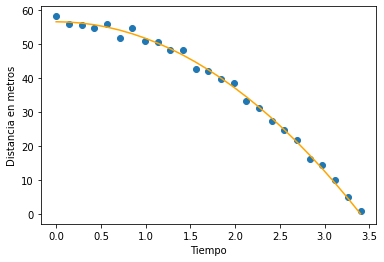

In [8]:
plt.scatter(tt,y)
plt.xlabel('Tiempo')
plt.ylabel('Distancia en metros')
plt.plot(tt,f, color='orange')
plt.show()

Pero pretendíamos ser Galileo, por lo que no conocemos los parámetros del modelo. Los datos sugieren que es una parábola, así que la modelamos como tal:

$$ Y_i = \beta_0 + \beta_1 x_i + \beta_2 x_i^2 + \varepsilon_i, i=1,\dots,n $$

¿Cómo encontramos la LSE?

#### La función `fit`

En Python podemos ajustar este modelo simplemente usando la función `fit`. Describiremos esta función en detalle más adelante, pero aquí hay una vista previa:

In [9]:
tt2 = tt * tt
y = f + rands
X2 = sma.add_constant(tt + tt2)
ols = sma.OLS(y, X2)
fit = ols.fit()
print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                     4240.
Date:                Sat, 29 Jan 2022   Prob (F-statistic):           1.37e-27
Time:                        23:36:07   Log-Likelihood:                -41.648
No. Observations:                  25   AIC:                             87.30
Df Residuals:                      23   BIC:                             89.73
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         58.7137      0.423    138.941      0.0

Nos da la LSE, así como los errores estándar y los valores de p.

Parte de lo que hacemos en esta sección es explicar las matemáticas detrás de esta función.

#### La estimación de mínimos cuadrados (LSE)

Escribamos una función que calcule el RSS para cualquier vector $\beta$:

In [10]:
def rss(Beta0,Beta1,Beta2):
    r = y - (Beta0 + Beta1 * tt + Beta2 * tt * tt)
    return(sum(r * r))

Así que para cualquier vector tridimensional obtenemos un RSS. Aquí hay una gráfica del RSS como una función de $\beta_2$ cuando mantenemos los otros dos fijos:

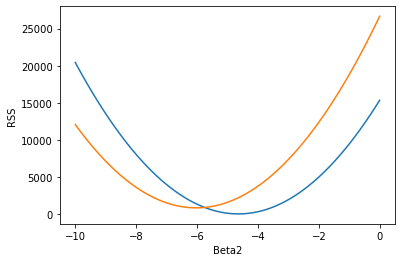

In [11]:
Beta2s = np.linspace(-10,0,num=100)
rss(Beta0=55,Beta1=0,Beta2=Beta2s)
plt.plot(Beta2s,rss(Beta0=55,Beta1=0,Beta2=Beta2s))
plt.xlabel('Beta2')
plt.ylabel('RSS')
## Agreguemos otra curva arreglando otro par:
Beta2s = np.linspace(-10,0,num=100)
plt.plot(Beta2s,rss(Beta0=65,Beta1=0,Beta2=Beta2s))
plt.show()

Prueba y error aquí no va a funcionar. En su lugar, podemos usar el cálculo: tomar las derivadas parciales, ponerlas a 0 y resolver. Por supuesto, si tenemos muchos parámetros, estas ecuaciones pueden volverse bastante complejas. El álgebra lineal proporciona una forma compacta y general de resolver este problema.


#### Más sobre Galton (avanzado)

Al estudiar los datos de padre e hijo, Galton hizo un descubrimiento fascinante mediante el análisis exploratorio.

![Trama de Galton.](http://upload.wikimedia.org/wikipedia/commons/b/b2/Galton's_correlation_diagram_1875.jpg)

Observó que si tabulaba el número de pares de estatura padre-hijo y seguía todos los valores x,y que tenían los mismos totales en la tabla, formaban una elipse. En el gráfico de arriba, hecho por Galton, ves la elipse formada por los pares que tienen 3 casos. Esto luego llevó a modelar estos datos como normal bivariado correlacionado que describimos anteriormente:

$$
Pr(X<a,Y<b) =
$$


$$
\int_{-\infty}^{a} \int_{-\infty}^{b} \frac{1}{2\pi\sigma_x\sigma_y\sqrt{1-\rho^2}}
\exp{ \left\{
\frac{1}{2(1-\rho^2)}
\left[\left(\frac{x-\mu_x}{\sigma_x}\right)^2 -  
2\rho\left(\frac{x-\mu_x}{\sigma_x}\right)\left(\frac{y-\mu_y}{\sigma_y}\right)+
\left(\frac{y-\mu_y}{\sigma_y}\right)^2
\right]
\right\}
}
$$

Describimos cómo podemos usar las matemáticas para mostrar que si mantiene fijo $X$ (la condición es que sea $x$), la distribución de $Y$ se distribuye normalmente con la media: $\mu_x +\sigma_y \rho \left(\frac {x-\mu_x}{\sigma_x}\right)$ y desviación estándar $\sigma_y \sqrt{1-\rho^2}$. Tenga en cuenta que $\rho$ es la correlación entre $Y$ y $X$, lo que implica que si fijamos $X=x$, $Y$ de hecho sigue un modelo lineal. Los parámetros $\beta_0$ y $\beta_1$ en nuestro modelo lineal simple se pueden expresar en términos de $\mu_x,\mu_y,\sigma_x,\sigma_y$ y $\rho$.